## Assignment 3: $k$ Nearest Neighbor

**Do two questions.**

`! git clone https://github.com/DS3001/knn`

**Q0.**
1. What is the difference between regression and classification?
* Regression helps predict continuous quantities, usually numerical, while classification helps predict discrete variables, like categorical values.

2. What is a confusion table? What does it help us understand about a model's performance?
* A confusion table is a table w/ two rows and two columns that shows the model's outputs for actual and predicted values + the faulty predictions like false pos/negs.

3. What does the SSE quantify about a particular model?
* The SSE is the sum squares error of a model. You take the difference between true and predicted values, square it, then sum over all predictions. The output is a measure of how far off the model is from the true statistic.

4. What are overfitting and underfitting? 
* Overfitting is when a model is too complex for the given data with extraneous DFs. Underfitting is when a model is too simple for the given data and is unable to properly capture key insights as to what's happening with the data.

5. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or SSE on the test set, improve model performance?
* Splitting the data into training/testing sets helps mimic the actual model in practice on potential data to give more accurate estimate of how the model would typically perform in general. The $k$ chosen will help reduce over/underfitting and reduce error overall to get the model as close to capturing true patterns as it can.

6. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.
* <u>Class label prediction</u>: Strengths: easy to interpret, quick, efficient bc only most likely class is reported, leaving out non-relevant info. Weaknesses: certainty/confidence isn't clear, limited info reported, 
* <u>Probability distribution</u>: Strengths: insight into confidence lvl/certainty, better interpretability with ambiguous cases. Weaknesses: can have unnecessary complexity if you just want a simple answer, higher costs in computations


**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `cars_env.csv` data. 

The variables that go into the model are one more dimension to think about: We can use the train-test split approach to pick the variables that go into the model, not just the number of neighbors.

1. Load the data. We're going to use `footprint`, `baseline mpg`, `baseline price`, and `baseline sales`. Prepare some EDA results for these variables: describe tables, histograms/kernel density plots, scatterplots, etc. I renamed these variables to `footprint`, `mpg`, `price`, and `sales` to save time.
2. Maxmin normalize `footprint`, `mpg`, and `price`. These will be our features/covariates $X$. Our target/dependent/outcome variable $y$ will be sales. Does it make sense to normalize $y$?
3. Make a 30% train-test split of the data into 30% test/validation data and 70% training data. 
4. Using all three covariates --- `footprint`, `mpg`, and `price` --- what's the best $k$ to use? What SSE is achieved on the test set? To answer these questions, evalute the sum of squared error on the test set for a reasonable range of values of $k$ (perhaps 2 to 150), and find the $k$ with the lowest SSE. 
5. Do part 4 again, for each pair of variables: `footprint` and `mpg`, `footprint` and `price`, `mpg` and `price`.
6. Which set of variables from parts 4 and 5 does the best, in terms of minimizing SSE at the optimal choice of neighbors? Explain.

In [1]:
# necessary imports 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# q3.1 #

df = pd.read_csv('./data/cars_env.csv')
# print(df.head())

df = df.loc[:, ['footprint','baseline mpg','baseline price', 'baseline sales']]
df = df.rename(columns = {'baseline mpg':'mpg', 'baseline price':'price', 'baseline sales':'sales'})

print(df.head())
df.describe()

   footprint        mpg        price    sales
0       50.8  22.052700  45706.20000  57380.0
1       45.1  24.174500  34588.20000  21271.0
2       47.6  24.562900  47934.90000   5132.0
3       47.8  27.068237  35217.81622  56720.0
4       46.0  29.855173  29483.10000  21996.0


,footprint,mpg,price,sales
count,524.000000,524.000000,5.240000e+02,524.000000
mean,49.427847,24.676600,5.165181e+04,24764.820399
std,7.915366,6.432016,8.968875e+04,41233.978890
min,36.692097,12.000000,1.178304e+04,1.000000
25%,44.200000,20.209807,2.521127e+04,2163.500000
50%,47.262519,23.782704,3.253602e+04,10157.000000
75%,52.598319,27.713313,5.098088e+04,27427.250000
max,77.500000,65.777800,1.734000e+06,335544.000000


<Axes: xlabel='price', ylabel='Count'>

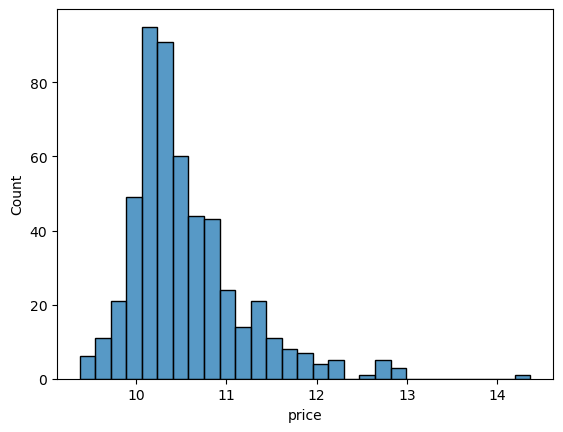

In [16]:
# sns.histplot(data = data, x = 'price')
sns.histplot(data = df, x = np.log(df['price']))

<Axes: xlabel='price', ylabel='Density'>

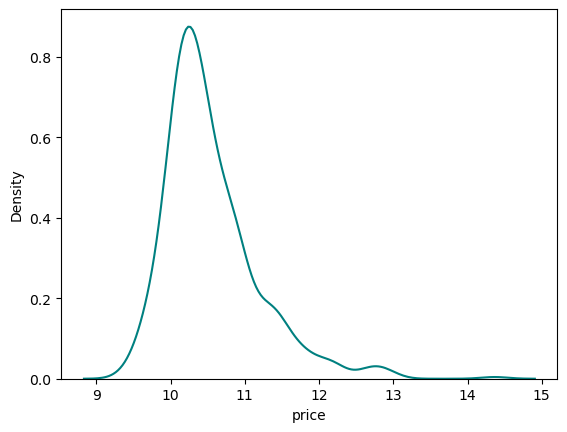

In [17]:
sns.kdeplot(data = df, x = np.log(df['price']), color = 'teal')

<Axes: xlabel='price', ylabel='footprint'>

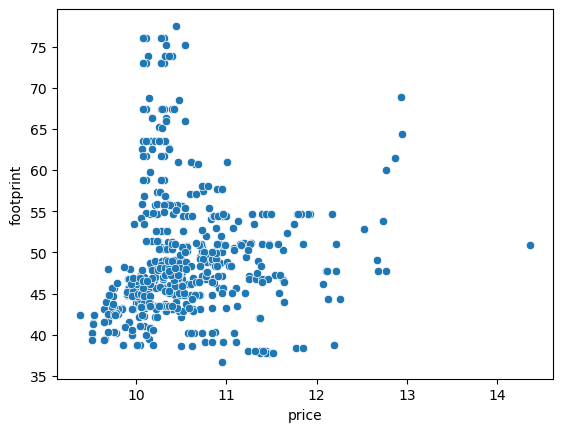

In [18]:
sns.scatterplot(data = df, x = np.log(df['price']), y = 'footprint')

In [21]:
# q3.2 #

X = df.loc[:, ['footprint', 'mpg', 'price']]
Y = df['sales']

def normalize(x):
    norm = (x - min(x)) / (max(x) - min(x))
    return norm

X = X.apply(normalize)
X.describe()

# does not make sense to normalize the target var, y; you normalized the covariates, x-vals, 
# so that each var has even/equal contribution to the model, but it's not needed for the target variable also bc we'd want
# sales in its actual units for better interpretation

,footprint,mpg,price
count,524.000000,524.000000,524.000000
mean,0.312090,0.235722,0.023150
std,0.193966,0.119604,0.052077
min,0.000000,0.000000,0.000000
25%,0.183982,0.152662,0.007797
50%,0.259029,0.219100,0.012050
75%,0.389783,0.292190,0.022760
max,1.000000,1.000000,1.000000


In [22]:
# q3.3 #
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html #

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state = 300)

[28]


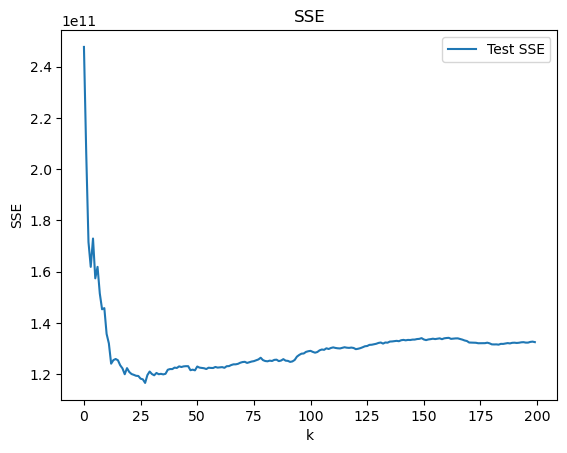

In [24]:
# q3.4 #
# https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html #

from sklearn.neighbors import KNeighborsRegressor 

k_bar = 200
SSE = np.zeros(k_bar)
SSE_on_train = np.zeros(k_bar)

for k in range(k_bar):
    model = KNeighborsRegressor(n_neighbors = k + 1)
    fitted_model = model.fit(x_train, y_train)
    y_hat = fitted_model.predict(x_test)
    SSE[k] = np.sum((y_test - y_hat) ** 2)
    y_hat = fitted_model.predict(x_train)
    SSE_on_train[k] = np.sum((y_train - y_hat) ** 2)

SSE_min = np.min(SSE)
min_index = np.where(SSE == SSE_min)
k_star = min_index[0] + 1
print(k_star)

plt.plot(np.arange(0, k_bar), SSE, label = 'Test SSE')
plt.xlabel("k")
plt.ylabel("SSE")
plt.legend(loc = 'upper right')
plt.title('SSE')
plt.show()

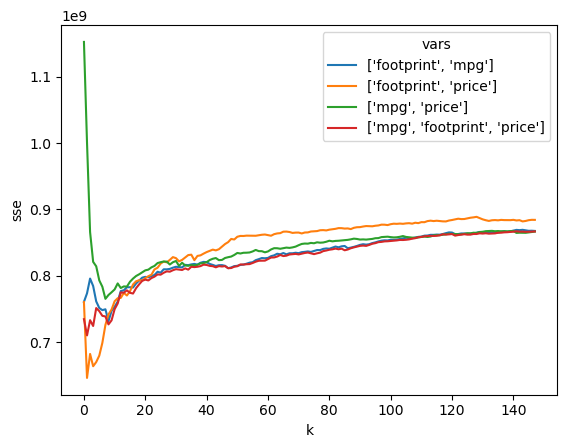

731732431.635937
646214942.2865593
765307146.4872227
710205461.4358218


In [48]:
# q3.5 #

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .40, random_state = 10000)

vars1 = ['footprint', 'mpg']
vars2 = ['footprint', 'price']
vars3 = ['mpg', 'price']
vars4 = ['mpg', 'footprint', 'price']

kgrid = np.arange(2, 150)
N = len(y)

SSE_results = []
y_hat_results = []
for var_list in [vars1, vars2, vars3, vars4]:
    x_train_1 = x_train.loc[:, var_list]
    x_test_1 = x_test.loc[:, var_list]
    SSE = np.zeros(len(kgrid))
    for k in range(len(kgrid)):
        model = KNeighborsRegressor(n_neighbors = kgrid[k])
        fitted_model = model.fit(x_train_1, y_train)
        y_hat = fitted_model.predict(x_test_1)
        y_hat_results.append(y_hat)
        SSE_results.append({'sse':np.sum((y_test - y_hat) ** 2) / N, 'vars':str(var_list), 'k':k})
gdf = pd.DataFrame.from_dict(SSE_results)

sns.lineplot(y = 'sse', x = 'k', data = gdf, hue = 'vars')
plt.show()

print(np.min(gdf.loc[gdf['vars'] == str(vars1), 'sse']))
print(np.min(gdf.loc[gdf['vars'] == str(vars2), 'sse']))
print(np.min(gdf.loc[gdf['vars'] == str(vars3), 'sse']))
print(np.min(gdf.loc[gdf['vars'] == str(vars4), 'sse']))

q3.6

Footprint and price (yellow) does the best in minimizing SSE, as evidenced by the graph since its line reaches the lowest SSE value. While it does reach the lowest SSE, it's primarily just for lower k values. As k increases, the yellow line eventually reaches a higher SSE than the other 3 relationship. As k gets larger, the line closest to the red line, which has all covariates, is the blue line, footprint and mpg. The lines seem to overlap almost perfectly with larger k's.